[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nepslor/B5203E-TSAF/blob/main/W3/fourier_forecasts_and_regression_solutions.ipynb)

# Fourier decomposition and forecasting
Under stationarity assumption, Fourier decomposition can be used to extrapolate a signal beyond observed values. In this lesson you'll write a simple Fourier forecaster from scratch. Let's start downloading some time series


array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

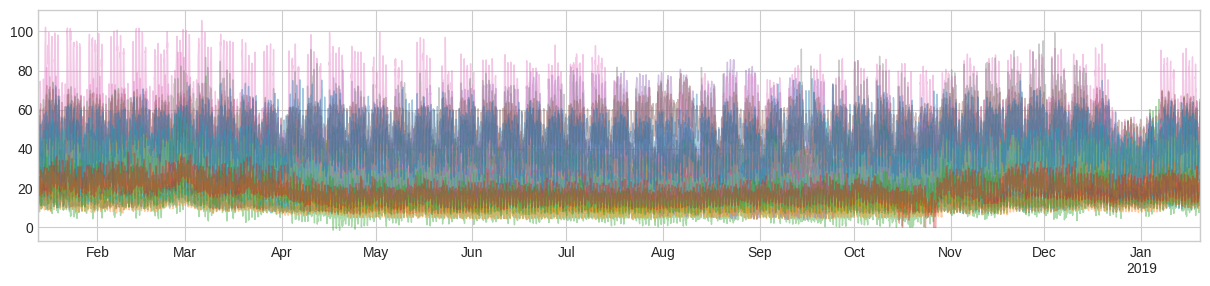

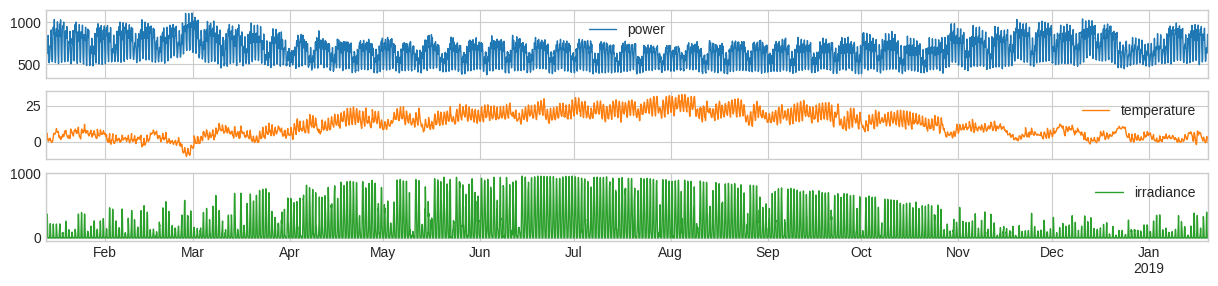

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_power = pd.read_pickle('https://github.com/nepslor/teaching/raw/refs/heads/main/TimeSeriesForecasting/data/power_dataset.pk')

plt.style.use("seaborn-v0_8-whitegrid")
df_power.filter(like='meter').plot(alpha=0.4, linewidth=1, legend=False, figsize=(15, 3))
df_power[['power', 'temperature', 'irradiance']].plot(linewidth=1, subplots=True, figsize=(15, 3))


## ❓ Generate the basis functions
Complete the following code that creates the first $n_h$ basis functions defined as:
$$P = \left[sin\left(\frac{2\pi tk}{l}\right), cos\left(\frac{2\pi tk}{l}\right)\right] \quad k\in \{1,\dots n_h\}$$
where $l$ is the length of $t \in \mathbb{N}^l$.

We then see that the cross-covariance matrix of these basis functions is normal, that is, off-diagonal elements are 0.

Remember that we have to normalize the signals to obtain ortho-**normal** basis. When we integrated the trigonometric functions over 2$\pi$, we shown tha the normalization constant was $\sqrt{\pi}$. Since we're now integrating over $l$, the normalization constant in this case is $\sqrt{l/2}$, that is the square root of half of the integration period:
$$ P_n = \sqrt{2/l} \left[sin\left(\frac{2\pi tk}{l}\right), cos\left(\frac{2\pi tk}{l}\right)\right] \quad k\in \{1,\dots n_h\}$$

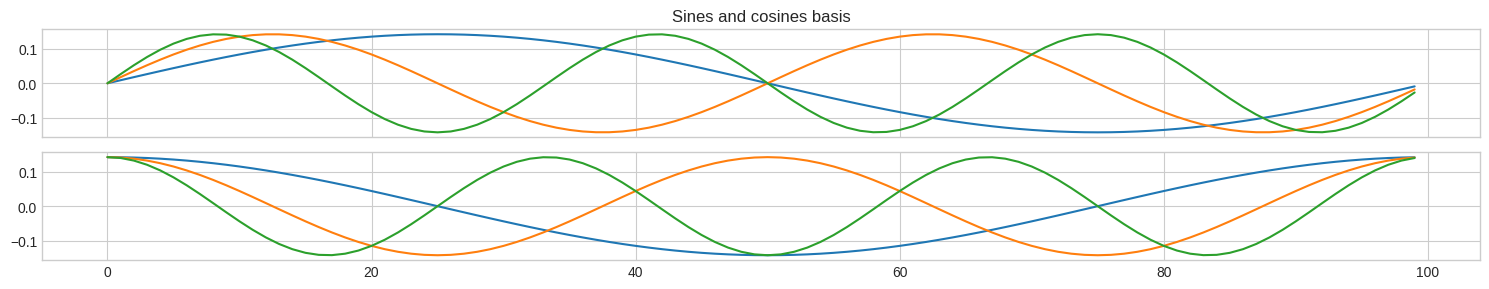

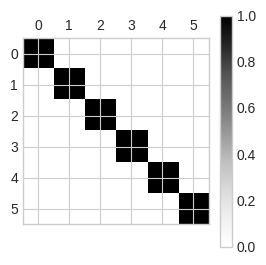

In [2]:

l=100               # lenght of the signal
n_h = 3             # number of harmonics to plot
t = np.arange(l)    # time vector

def get_basis(t, l, n_h):
  """
  Get the first n_h sine and cosine basis functions and the projection
  matrix P
  """
  sines = np.vstack([np.sin(2*np.pi*k*t/l) for k in np.arange(n_h)+1])
  cosines = np.vstack([np.cos(2*np.pi*k*t/l) for k in np.arange(n_h)+1])
  P = np.vstack([sines, cosines]).T * np.sqrt(2 / l)
  return P

P = get_basis(t, l, n_h)
sines, cosines = P[:, :n_h].T, P[:, n_h:].T

fig, ax = plt.subplots(2, 1, figsize=(15, 3), layout="tight")
ax[0].plot(sines.T)
ax[0].set_xticklabels([])
ax[1].plot(cosines.T)
ax[0].set_title('Sines and cosines basis')

fig, ax = plt.subplots(figsize=(3, 3))
m = ax.matshow(P.T@P)
plt.colorbar(m)



The following is just an utility function to remove the mean from the power signal and return a training and a test set.

In [3]:
def get_tr_te(p, training_steps, steps_ahead):
  x_tr = p.iloc[:training_steps].values
  tr_mean = np.mean(x_tr)
  x_tr -= tr_mean
  x_te = p.iloc[training_steps:training_steps+steps_ahead].values
  x_te -= tr_mean
  return x_tr, x_te

steps_ahead = 24*14
training_steps = 24*7

x_tr, x_te = get_tr_te(df_power['power'], training_steps, steps_ahead)

# ❓ Write a Fourier forecaster
Once you have created the basis function with the same length of the training signal, you have to project the original signal onto the basis. Since the basis matrix is orthonormal:
$$\beta = (P^TP)^{-1}(P^Tx) =I(P^Tx)=
 P^Tx$$

In order to extrapolate you just have to create a longer basis matrix $P$ and obtain the extrapolated signal using $\beta$.

You can reuse the `get_basis` function to define a new matrix, $P_{fore}$, defined over $l + l_{fore}$ where $l_{fore}$ is the length of the step ahead to be forecasted.



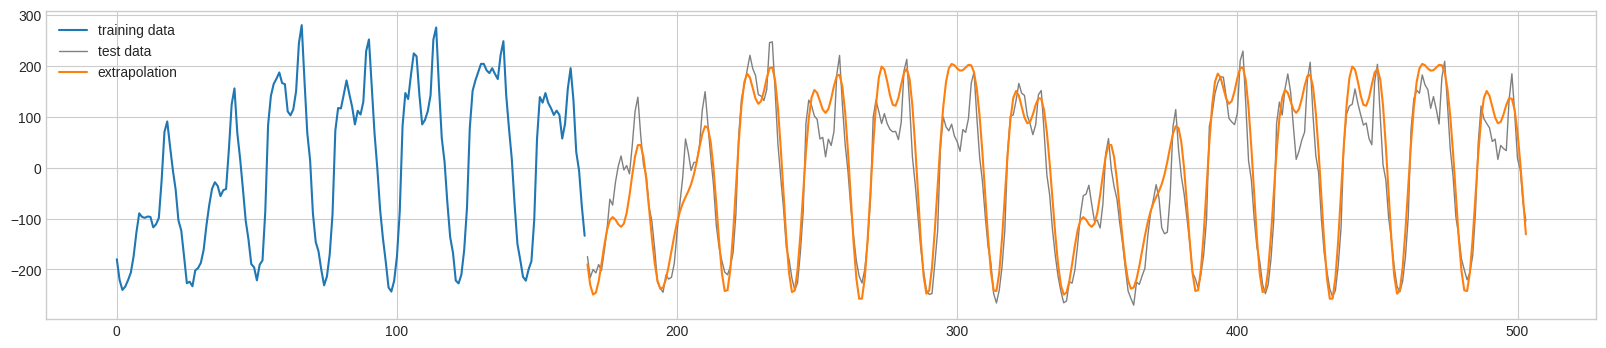

In [4]:
l_tr=len(x_tr)
l_te=len(x_te)
t_tr = np.arange(l_tr)
t_te = np.arange(l_tr, l_tr+l_te)
n_harmonics = 20

# ------------- Fourier decomposition - linear regression fit -----------------
P = get_basis(t_tr, l_tr, n_harmonics)

# since the basis is orthonormal the following is equivalent to the standard linear regression solution
coeffs = P.T@x_tr

# ------------- Extrapolation - we fix the frequencies and retrieve longer basis

P_pred = get_basis(t_te, l_tr, n_harmonics) # l is the fundamental period, must stay fixed



plt.subplots(1, 1, figsize=(20, 4))
plt.plot(x_tr, label='training data')
plt.plot(np.hstack([x_tr*np.nan, x_te]), color='grey', linewidth=1, label='test data')
plt.plot(t_te, P_pred@coeffs, label='extrapolation')
plt.legend();

# ❓ What's the optimal $n_h$?
Write a function to get the MAE on the test set, then write an optimizer to obtain the optimal value of $n_h$


our method explored 128 solutions in 0.44065165519714355s


/tmp/ipykernel_12432/4973678.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend();


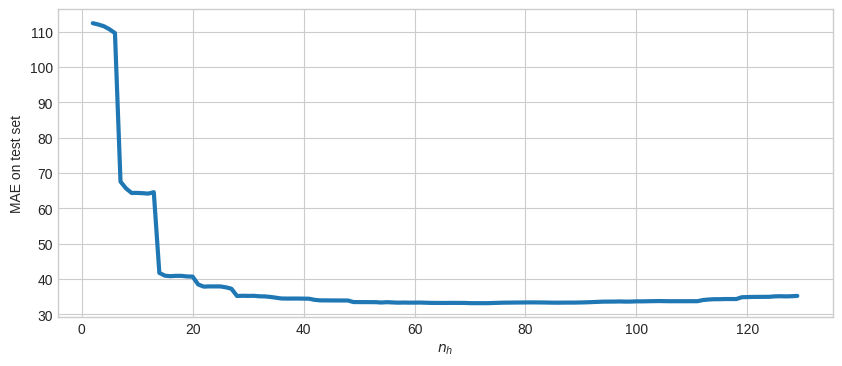

In [5]:
from time import time
n_harmonics = np.arange(2, 130)
mae= np.zeros(len(n_harmonics))
mae_fun = lambda err: np.mean(np.abs(err))

t0=time()
for i, n_h in enumerate(n_harmonics):
  P = get_basis(t_tr, l_tr, n_h)
  coeffs = P.T@x_tr
  P_pred = get_basis(t_te, l_tr, n_h)
  x_hat_1 = P_pred@coeffs
  mae[i] = mae_fun(x_hat_1-x_te)
print('our method explored {} solutions in {}s'.format(len(n_harmonics), time()-t0))

plt.subplots(1, 1, figsize=(10, 4))
plt.plot(n_harmonics, np.array(mae), linewidth=3)
plt.ylabel('MAE on test set')
plt.xlabel('$n_h$')
plt.legend();

# Fourier forecaster via Nixtla
The Nixtlaverse is composed by our open-source libraries, designed to provide a comprehensive, cutting-edge toolkit for time series forecasting in python.

In the following we'll see how a similar Fourier forecaster can be written using Nixtla


In [6]:
%%capture
!pip install mlforecast
!pip install utilsforecast
from utilsforecast.feature_engineering import trend, fourier, pipeline
from sklearn.linear_model import LinearRegression
from mlforecast import MLForecast
from utilsforecast.feature_engineering import fourier, pipeline
from functools import partial
from utilsforecast.plotting import plot_series

The first step is to convert our timeseries in a nixtla-compatible format: we need an `unique_id` column with a tag for the name of the timeseries, a 'ds' timestamp and the 'y' containing the actual values:

| unique_id | ds         | y         |
|-----------|------------|-----------|
| id_00     | 2000-01-01 | 17.519167 |
| id_00     | 2000-01-02 | 87.799695 |
| id_00     | 2000-01-03 | 177.442975|
| id_00     | 2000-01-04 | 232.704110|
| id_00     | 2000-01-05 | 317.510474|

In [7]:
def convert_to_nixtla_ts(series):
  """
  Transform a pandas series to a nixtla-compatible df
  """
  name = series.name
  series = series.reset_index(name='y')
  df = pd.DataFrame(series.rename(columns={'index': 'ds'}))
  df['unique_id'] = name
  return df

print('#'*40)
print('original series')
print('#'*40)

print(df_power['power'].head())

df_nixtla = convert_to_nixtla_ts(df_power['power'])
print('#'*40)
print('nixtla compatible df')
print('#'*40)

print(df_nixtla.head())


########################################
original series
########################################
2018-01-13 00:00:00+00:00   -179.922394
2018-01-13 01:00:00+00:00   -220.849827
2018-01-13 02:00:00+00:00   -240.195549
2018-01-13 03:00:00+00:00   -233.736994
2018-01-13 04:00:00+00:00   -221.069105
Freq: h, Name: power, dtype: float64
########################################
nixtla compatible df
########################################
                         ds           y unique_id
0 2018-01-13 00:00:00+00:00 -179.922394     power
1 2018-01-13 01:00:00+00:00 -220.849827     power
2 2018-01-13 02:00:00+00:00 -240.195549     power
3 2018-01-13 03:00:00+00:00 -233.736994     power
4 2018-01-13 04:00:00+00:00 -221.069105     power


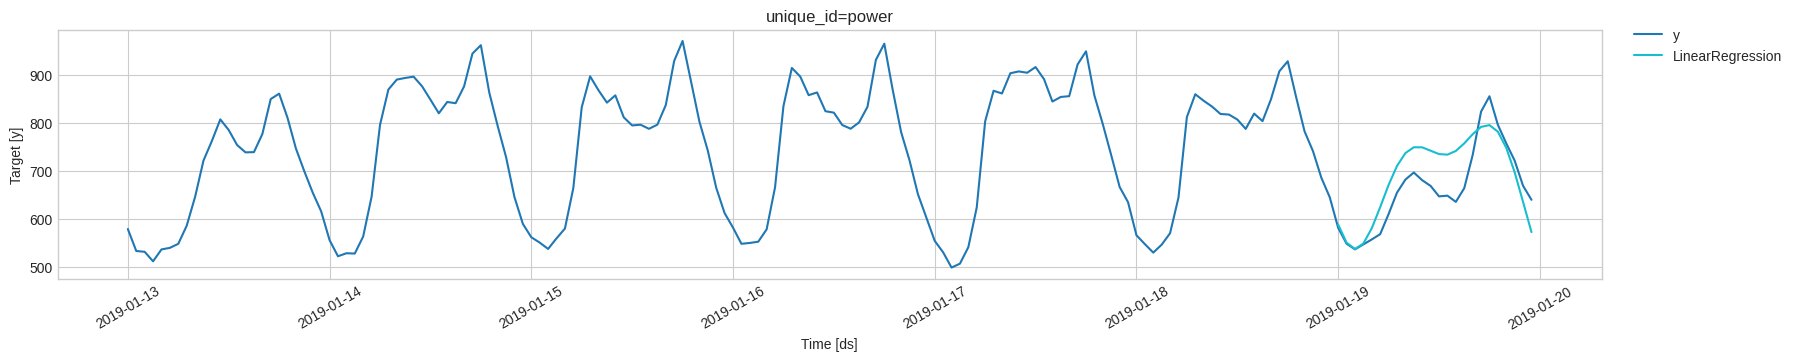

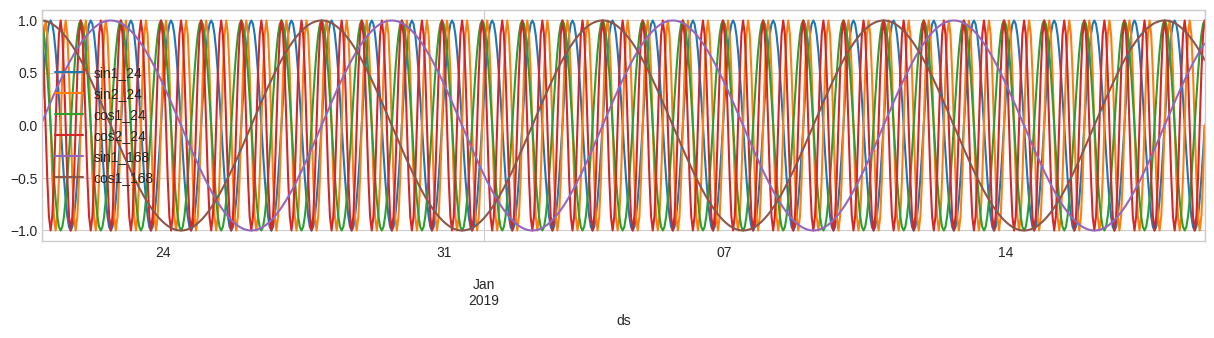

In [8]:
# Step 1: Define Fourier features
features = [
    partial(fourier, season_length=24, k=2),
    partial(fourier, season_length=24*7, k=1)
]

# Step 2: Run the pipeline to create training and future features
# df must contain columns: ['unique_id', 'ds', 'y']
train_df, future_df = pipeline(
    df_nixtla.iloc[-24*30:-24],
    features=features,
    freq='1h',
    h= 24
    )

train_df[[c for c in train_df.columns if 'y' not in c]].plot(x='ds', figsize=(15, 3))

sf = MLForecast(
    models=[LinearRegression()],
    freq='1h',
    lags=[1]
)

sf = sf.fit(train_df, static_features=[])

predictions = sf.predict(h=24, X_df=future_df)
plot_series(df_nixtla.tail(24*7), predictions)

In [9]:
#@title Interactive Fourier model

import ipywidgets as widgets
from IPython.display import display



def fourier_interactive(df_nixtla, p_1 = 24, p_2 = 24 * 7):
  # Create dropdown to toggle order
  k1_slider = widgets.IntSlider(value=1, min=1, max=50, step=1, description='k1 (daily)', continuous_update=False)
  k2_slider = widgets.IntSlider(value=1, min=1, max=50, step=1, description='k2 (weekly)', continuous_update=False)


  def update_plot(k1, k2):

        features = [
            partial(fourier, season_length=p_2, k=k2),       # weekly
            partial(fourier, season_length=p_1, k=k1),         # daily
        ]
        # Step 2: Run the pipeline to create training and future features
        # df must contain columns: ['unique_id', 'ds', 'y']
        train_df, future_df = pipeline(
            df_nixtla.tail(p_1+p_2)[:-p_1],
            features=features,
            freq='1h',
            h= p_1
        )


        sf = MLForecast(
            models=[LinearRegression(fit_intercept=True)],
            freq='1h',
            lags=[1]
        )

        sf = sf.fit(train_df, static_features=[])

        predictions = sf.predict(h=p_1, X_df=future_df)
        predictions = predictions.rename(columns={'LinearRegression': 'y'})
        fig, ax = plt.subplots(1, 1, figsize=(20, 4))
        df_nixtla.tail(p_1 + p_2).plot(x='ds', y='y', ax=ax)
        predictions.plot(x='ds', y='y', ax=ax)
        # plot ground truth

        plt.show()

  # Link widget to function
  ui = widgets.VBox([k1_slider, k2_slider])
  out = widgets.interactive_output(update_plot, {'k1': k1_slider, 'k2': k2_slider})

  return display(ui, out)

fourier_interactive(df_nixtla)

Output()